In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display


In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


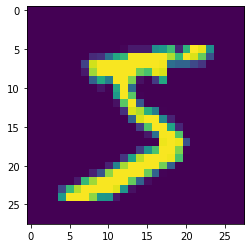

In [5]:
plt.imshow(train_images[0])

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [7]:
buffer_size = 60000
batches = 256
type(train_images[0])

numpy.ndarray

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(True).batch(batches)

In [8]:
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    # model oputput shape is (batch_size , 7 ,7 , 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # h1=7 , padding=same , stride=1 -> 7*1 = 7
    # model oputput shape is (batch_size , 7 ,7 , 128)

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # h1=7 , padding=same , stride=2 -> 7*2 = 14
    # model oputput shape is (batch_size , 14 ,14 , 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # h1=14 , padding=same , stride=2 -> 14*2 = 28
    # model oputput shape is (batch_size , 28 ,28 , 1)

    return model

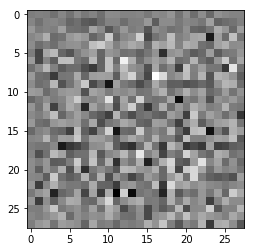

In [9]:
G = Generator()

noise = tf.random.normal([1, 100])
generated_image_test = G(noise, training=False)

plt.imshow(generated_image_test[0, :, :, 0], cmap='gray')

In [0]:
def Discriminator():
    model = tf.keras.Sequential()
    # Generator output shape was (batch_size , 28, 28, 1)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [19]:
D = Discriminator()
decisioned_generated_image_test = D(generated_image_test)

for images in train_dataset:
  break
  
real_image_test = np.expand_dims(images[0],axis=0)
decisioned_real_image_test = D(real_image_test)
print (decisioned_generated_image_test , decisioned_real_image_test)

tf.Tensor([[-0.00193947]], shape=(1, 1), dtype=float32) tf.Tensor([[0.00200565]], shape=(1, 1), dtype=float32)


In [0]:
# defining loss , both models are binary
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# for real image, must be ones and for fake images zeros, and total loss is sum of both
# using tf.ones_like(real_output) due to batch_size that is not always same 
def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
# against discriminator, generator only has fake images 
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [45]:
EPOCHS = 60
BATCH_SIZE = 16
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [46]:
G.load_weights('Gen_weights.h5')
D.load_weights('Dis_weights.h5')

NameError: name 'D' is not defined

In [27]:
for epoch in range(EPOCHS):
  i = 0
  for images in train_dataset:
    print(f'{epoch} - {i}')
    i += 1
    noise = tf.random.normal([16, noise_dim])

    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
      generated_images = G(noise, training=True)

      real_output = D(images, training=True)
      fake_output = D(generated_images, training=True)

      gen_loss = G_loss(fake_output)
      disc_loss = D_loss(real_output, fake_output)

    gradients_of_generator = G_tape.gradient(gen_loss, G.trainable_variables)
    gradients_of_discriminator = D_tape.gradient(disc_loss, D.trainable_variables)

    G_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
    D_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))
  if epoch%10==0:
    G.save_weights('Gen_weights.h5')
    D.save_weights('Dis_weights.h5')
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(0))
    plt.show()


Streaming output truncated to the last 5000 lines.
38 - 171
38 - 172
38 - 173
38 - 174
38 - 175
38 - 176
38 - 177
38 - 178
38 - 179
38 - 180
38 - 181
38 - 182
38 - 183
38 - 184
38 - 185
38 - 186
38 - 187
38 - 188
38 - 189
38 - 190
38 - 191
38 - 192
38 - 193
38 - 194
38 - 195
38 - 196
38 - 197
38 - 198
38 - 199
38 - 200
38 - 201
38 - 202
38 - 203
38 - 204
38 - 205
38 - 206
38 - 207
38 - 208
38 - 209
38 - 210
38 - 211
38 - 212
38 - 213
38 - 214
38 - 215
38 - 216
38 - 217
38 - 218
38 - 219
38 - 220
38 - 221
38 - 222
38 - 223
38 - 224
38 - 225
38 - 226
38 - 227
38 - 228
38 - 229
38 - 230
38 - 231
38 - 232
38 - 233
38 - 234
39 - 0
39 - 1
39 - 2
39 - 3
39 - 4
39 - 5
39 - 6
39 - 7
39 - 8
39 - 9
39 - 10
39 - 11
39 - 12
39 - 13
39 - 14
39 - 15
39 - 16
39 - 17
39 - 18
39 - 19
39 - 20
39 - 21
39 - 22
39 - 23
39 - 24
39 - 25
39 - 26
39 - 27
39 - 28
39 - 29
39 - 30
39 - 31
39 - 32
39 - 33
39 - 34
39 - 35
39 - 36
39 - 37
39 - 38
39 - 39
39 - 40
39 - 41
39 - 42
39 - 43
39 - 44
39 - 45
39 - 46
39 - 47

<Figure size 432x288 with 0 Axes>

In [0]:
G.save_weights('Gen_weights.h5')
D.save_weights('Dis_weights.h5')

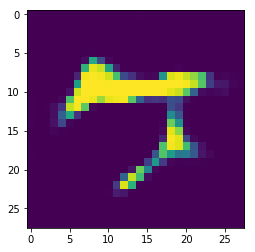

In [48]:
noise = tf.random.normal([16, noise_dim])
img = G(noise)
plt.imshow(img[2,:,:,0])